In [1]:
import glob
import os
import numpy as np
import yaml
import astropy.units as u
from astropy.io import ascii
import os
import matplotlib.pyplot as plt
import json
import subprocess
dir = '23dec20' # enter date string here

## Read and plot data

In [2]:
os.system('cat /mnt/data/dsa110/T2/'+dir+'/*.cand > tmp.dat')
snr,it,itime,mjds,ibox,idm,dm,memb,ibeam = np.loadtxt('tmp.dat').transpose()

/mnt/data/dsa110/T3/scripts
0 305281984 5.557638888888889 9.34449 214.214 175 fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out fl_2.out
1 1106608192 20.145333333333333 8.77378 116.95 52 fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out fl_7.out
2 297177504 5.410083333333333 9.27948 152.704 184 fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out fl_0.out
3 758188912 13.802555555555555 8.67327 101.649 102 fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out fl_6.out
4 580700480 10.571472222222223 8.72969 224.499 79 fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out fl_4.out
5

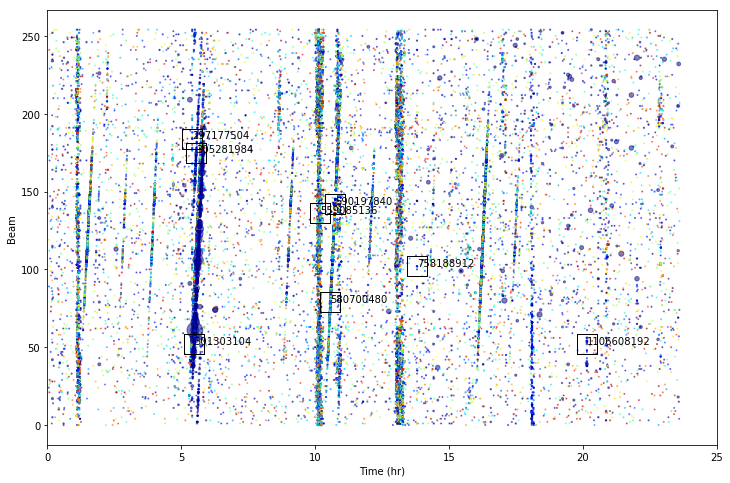

In [3]:
plt.figure(figsize=(12,8))
plt.xlabel('Time (hr)')
plt.ylabel('Beam')
s = snr**3.5
s /= np.min(s)
dmc = dm/np.max(dm)
x1 = 0. # set xlim in hr
x2 = 25. # set xlim in hr
plt.xlim(x1,x2)
plt.scatter(mjds/3600.,ibeam,s=s,alpha=0.5,cmap='jet',c=dmc)
fls = glob.glob('/mnt/data/dsa110/T2/'+dir+'/*.json')
for fl in fls:
    f = open(fl)
    d = json.load(f)  
    snum = int(list(d.keys())[0])
    snum2 = 16*(snum-477)
    val = list(d.values())[0]
    plt.plot([float(val['mjds'])/3600.],[float(val['ibeam'])],'s',markersize=20.,markeredgecolor='black',markerfacecolor='none')
 
%cd /mnt/data/dsa110/T3/scripts
cmd = ['python', 'gen_catalog.py', dir]
p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
p.wait()
metadata = np.load(dir+'_cat.npz')['metadata']
i = 0
for mm in metadata:
    if float(mm[1])/3600. > x1:
        if float(mm[1])/3600. < x2:
            plt.plot([float(mm[1])/3600.],[float(mm[4])],'s',markersize=20.,markeredgecolor='black',markerfacecolor='none')
            plt.text(float(mm[1])/3600.,float(mm[4]),str(mm[0]),fontsize=10)
            print(i,mm[0],float(mm[1])/3600.,mm[2],mm[3],mm[4],mm[5])
            i += 1

## Now run through baseband processing for any interesting candidates

In [4]:
# This copies the latest bf weights and the data files
cmd = ['./cp_weights_corr22.bash']
p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
for line in p.stdout:
    print(line)
p.wait()
os.system('./cp_corr22.bash '+metadata[3][5]) # edit first index to match line number above

0

In [6]:
# This forms the coherent beam
os.system('./run_bf_corr22.bash '+metadata[3][4])

0

In [7]:
# This copies the data across
os.system('cd ~/data; scp ubuntu@corr22.sas.pvt:./data/spliced.fil .')

0

In [8]:
# The rest is up to you! You can use sigpyproc to plot up stuff

from sigpyproc.Readers import FilReader
%cd /home/user/data
f = FilReader('spliced.fil')
f.header

/mnt/data/dsa110


{'telescope_id': 66,
 'az_start': 0.0,
 'nbits': 8,
 'source_name': 'source',
 'data_type': 1,
 'nchans': 6144,
 'machine_id': 99,
 'tsamp': 3.2768e-05,
 'foff': -0.03051757812,
 'nbeams': 102,
 'fch1': 1498.75,
 'tstart': 55000.0,
 'nifs': 1,
 'hdrlen': 250,
 'filelen': 754974970,
 'nbytes': 754974720,
 'nsamples': 122880,
 'filename': 'spliced.fil',
 'basename': 'spliced',
 'extension': '.fil',
 'bandwidth': 187.49999996928,
 'ftop': 1498.76525878906,
 'fbottom': 1311.26525881978,
 'fcenter': 1405.01525880442,
 'tobs': 4.0265318400000005,
 'src_raj': 0,
 'src_dej': 0,
 'ra': '00:00:00.0000',
 'dec': '00:00:00.0000',
 'ra_rad': 0.0,
 'dec_rad': 0.0,
 'ra_deg': 0.0,
 'dec_deg': 0.0,
 'obs_date': '17/06/2009',
 'obs_time': '00:00:00.00000',
 'dtype': '<u1'}


Filterbank reading plan:
------------------------
Called on file:        spliced.fil
Called by:             dedisperse
Number of samps:       122880
Number of reads:       14
Nsamps per read:       10000
Nsamps of final read:  7450
Nsamps to skip back:   1755

Execution time: 2.396539 seconds     



Text(0,0.5,'power')

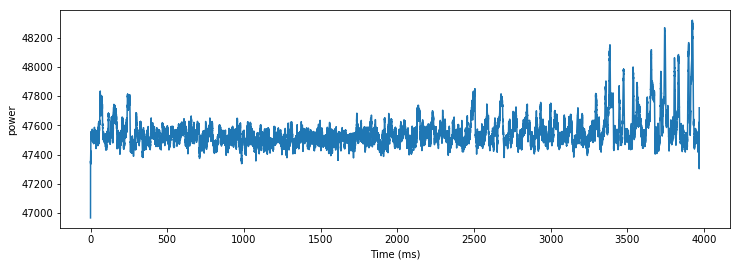

In [10]:
ts = f.dedisperse(101.649)
fts = ts.applyBoxcar(128)
x = np.arange(len(fts))*f.header['tsamp']*1e3
plt.figure(figsize=(12,4.))
plt.plot(x,fts)
plt.xlabel('Time (ms)')
plt.ylabel('power')
#plt.xlim(400.,800.)

In [11]:
dnam = f.downsample(tfactor=32,ffactor=16,filename='scrunch.fil')
d = FilReader(dnam)
da = d.readBlock(0,d.header['nsamples'])


Filterbank reading plan:
------------------------
Called on file:        spliced.fil
Called by:             downsample
Number of samps:       122880
Number of reads:       240
Nsamps per read:       512
Nsamps of final read:  512
Nsamps to skip back:   0

Execution time: 0.885294 seconds     



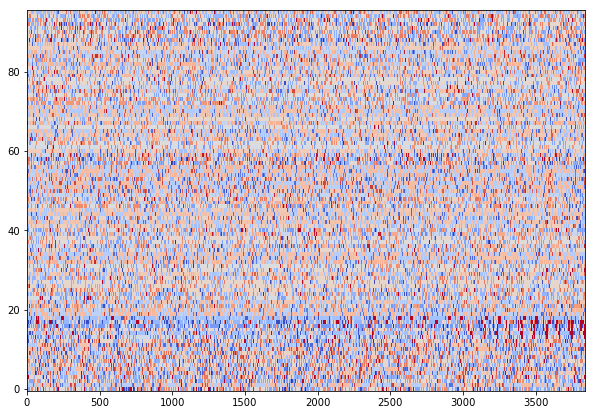

In [12]:
plt.figure(figsize=(10,7))
mnspec = da.mean(axis=1)
for i in range(da.shape[1]):
    da[:,i] -= mnspec
da = np.reshape(da,(int(da.shape[0]/4),4,da.shape[1])).mean(axis=1)
plt.imshow(da,origin='lower',aspect='auto',cmap='coolwarm',vmin=-2.*np.std(da),vmax=2.*np.std(da))